In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset='/content/drive/MyDrive/braintumor/braintumordataset'

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   ├── MyDrive
│   │   ├── 16010122282,16010122222,16010122277_DS_IA2_NOV22
│   │   ├── Assignments
│   │   │   └── Biology for Engineers_Sem-II_2022-23
│   │   │       ├── Assignment 3
│   │   │       ├── Assignment 4
│   │   │       ├── Assignment 5
│   │   │       └── IA2 Report Writing
│   │   ├── braintumor
│   │   │   └── brain_tumor_dataset
│   │   │       ├── no
│   │   │       └── yes
│   │   ├── Classroom
│   │   │   ├── AC Honors 2023-24
│   │   │   ├── AC Honors  July 2023- Batch II
│   │   │   ├── CSFCL (Honors) 2023-24
│   │   │   ├── Data S C2 July 2023
│   │   │   ├── Data S C Div July 2023
│   │   │   ├── DBMS- A3-23-24
│   │   │   ├── OOPM C2
│   │   │   ├── OOPM LAB (Comps) 23-24 SY B.Tech C2
│   │   │   ├── OOPM S.Y. B.Tech Comps 23-24 DIVISION C
│   │   │   ├── Python Programming
│   │   │   ├── RDBMS lab C3 Batch (2023-24)
│   │   │   ├── RDBMS Theory C Division (2023-24)
│   │   │   ├── SY C3 Mini Project Jan 2024
│   │   │   ├── SY C COMP_TACD 2023-

In [ ]:
IMG_PATH = '/content/drive/MyDrive/braintumor/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
def load_data(dir_path, img_size=(100, 100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    img = cv2.resize(img, img_size)  # Resize image to specified size
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 120.38it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 11.44it/s]

50 images loaded from VAL/ directory.


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

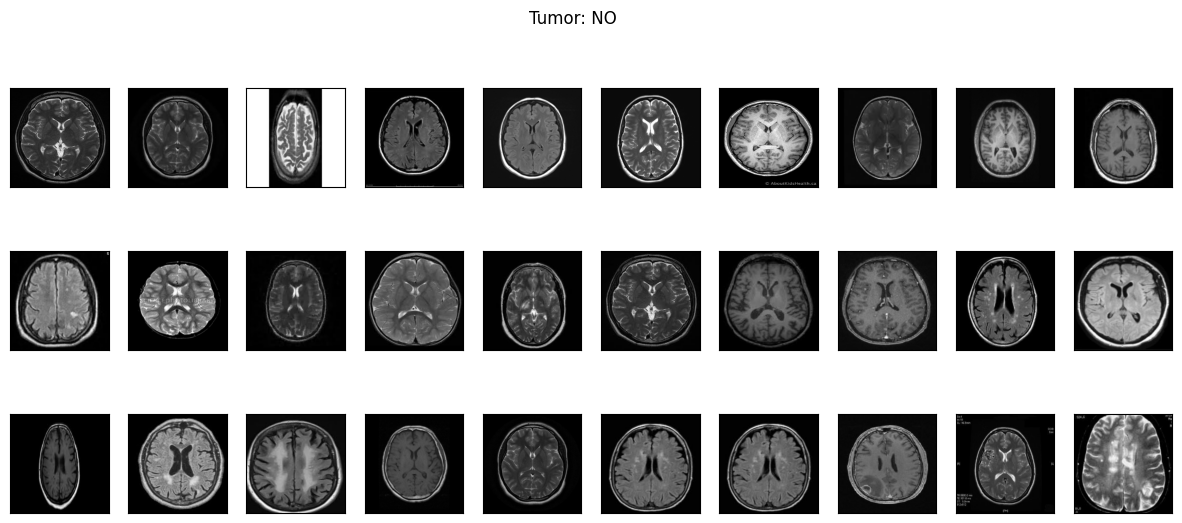

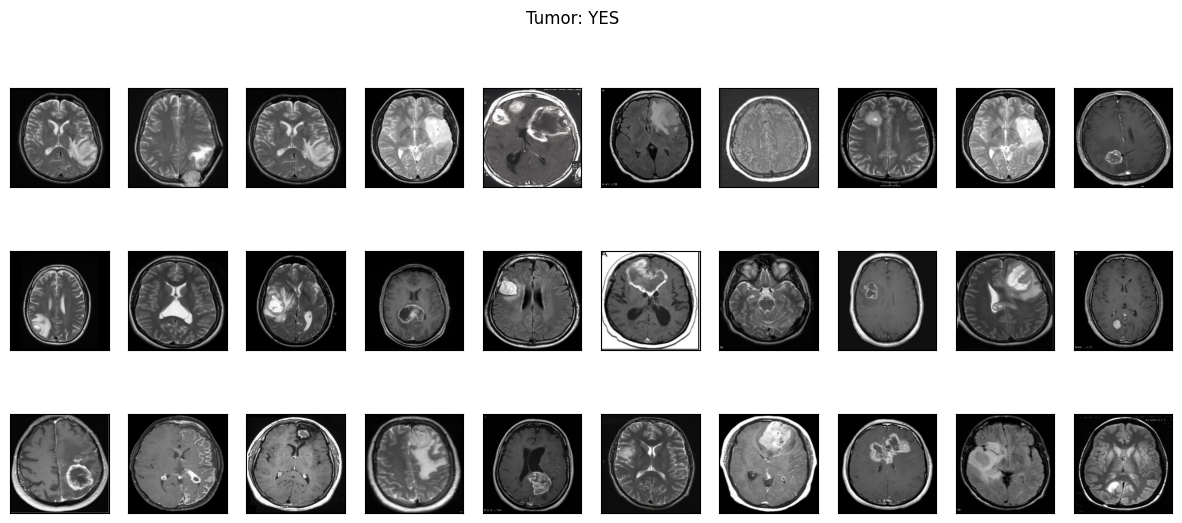

In [ ]:
plot_samples(X_train, y_train, labels, 30)

In [ ]:
def crop_imgs(set_name, add_pixels_value=0, target_size=(224, 224)):
    """
    Finds the extreme points on the image, crops the rectangular out of them, and resizes to the target size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS,
                      extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Resize the image to the target size
        new_img = cv2.resize(new_img, target_size)

        set_new.append(new_img)

    return np.array(set_new)


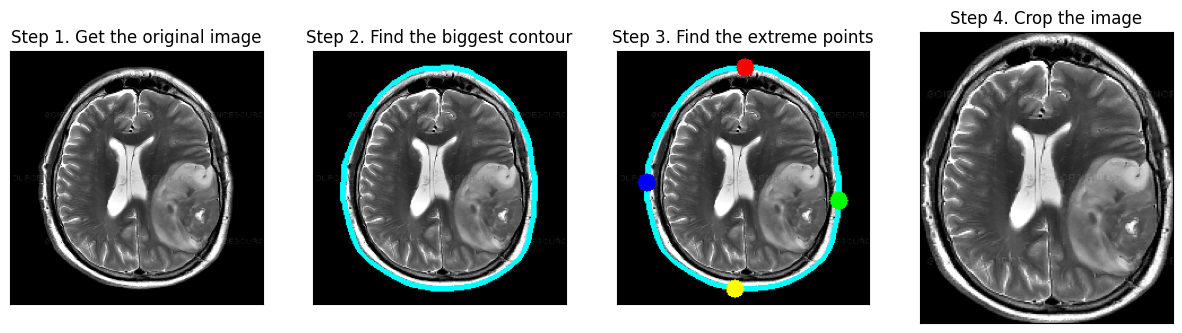

In [ ]:
img = cv2.imread('/content/drive/MyDrive/braintumor/brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

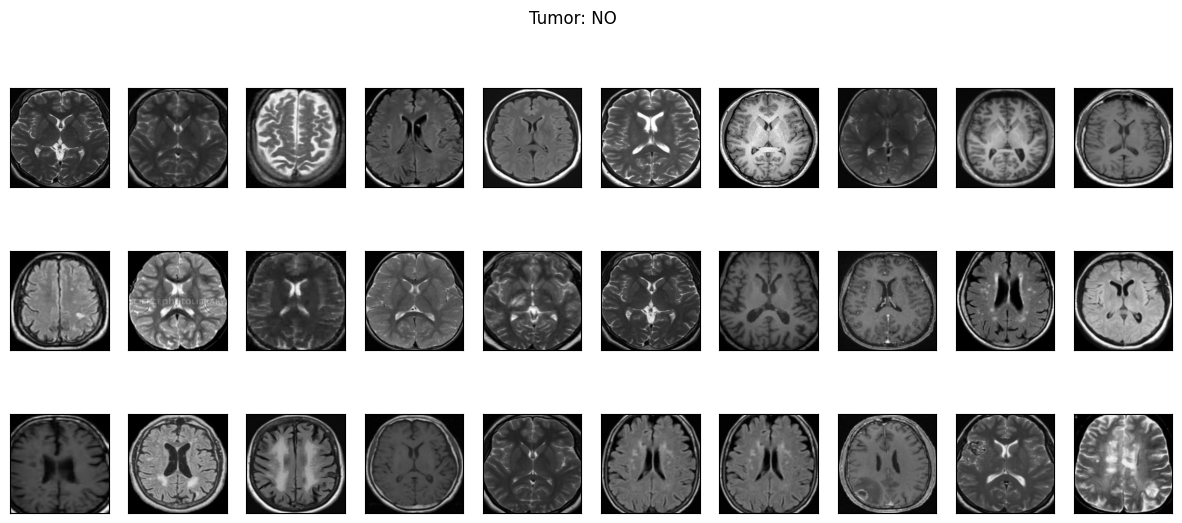

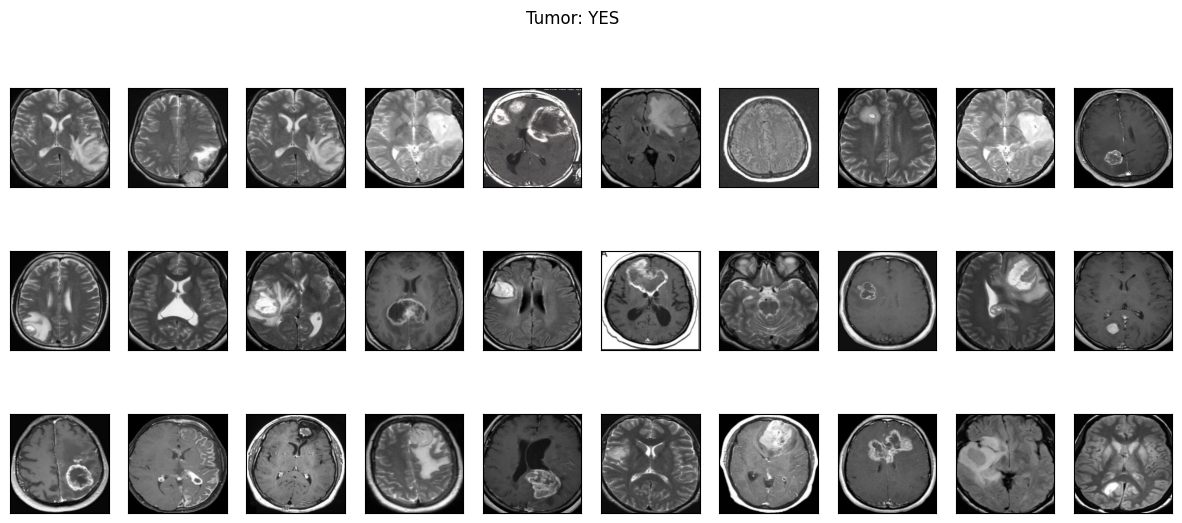

In [ ]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

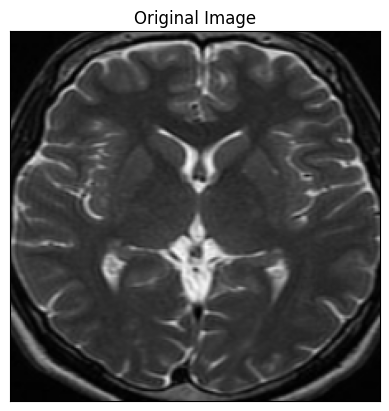

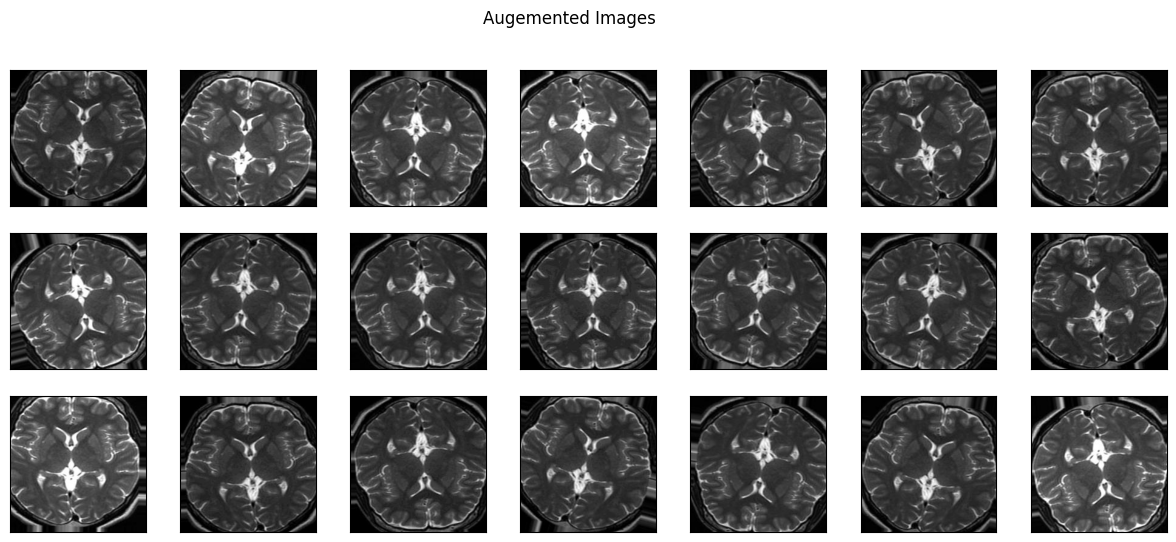

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
!rm -rf preview/

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

TRAIN_RANDOM_SEED = 42
VAL_RANDOM_SEED = 123

train_datagen = ImageDataGenerator(
    rotation_range=30,  # Increase rotation range
    width_shift_range=0.2,  # Increase width shift range
    height_shift_range=0.2,  # Increase height shift range
    shear_range=0.2,  # Increase shear range
    zoom_range=0.2,  # Add zooming
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=TRAIN_RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=VAL_RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16

# Load the VGG16 model with pre-trained ImageNet weights
base_model = VGG16(
    weights='imagenet',         # Use pre-trained ImageNet weights
    include_top=False,          # Exclude the fully-connected layers
    input_shape=(224, 224, 3)   # Input shape of the images
)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
EPOCHS = 15
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=3,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3,
    callbacks=[es]
)

Epoch 1/15
3/3 [==============================] - 8s 3s/step - loss: 1.6155 - accuracy: 0.7812 - val_loss: 0.7295 - val_accuracy: 0.8333
Epoch 2/15
3/3 [==============================] - 2s 642ms/step - loss: 1.3033 - accuracy: 0.8021 - val_loss: 1.0947 - val_accuracy: 0.7917
Epoch 3/15
3/3 [==============================] - 2s 633ms/step - loss: 0.7593 - accuracy: 0.8854 - val_loss: 0.7164 - val_accuracy: 0.8542
Epoch 4/15
3/3 [==============================] - 2s 615ms/step - loss: 1.8566 - accuracy: 0.7812 - val_loss: 0.6999 - val_accuracy: 0.8958
Epoch 5/15
3/3 [==============================] - 2s 770ms/step - loss: 1.7359 - accuracy: 0.7917 - val_loss: 0.7272 - val_accuracy: 0.8750
Epoch 6/15
3/3 [==============================] - 2s 671ms/step - loss: 1.5794 - accuracy: 0.8000 - val_loss: 0.6886 - val_accuracy: 0.8958
Epoch 7/15
3/3 [==============================] - 1s 392ms/step - loss: 2.7524 - accuracy: 0.7385 - val_loss: 0.9885 - val_accuracy: 0.8333
Epoch 8/15
3/3 [=======

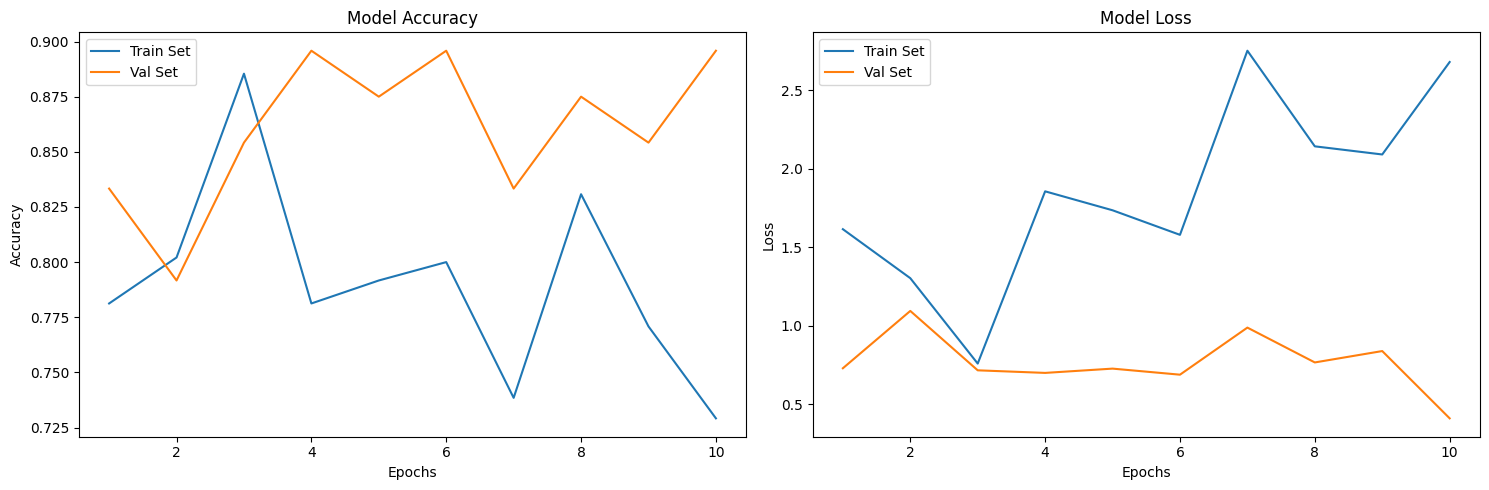

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()


2/2 [==============================] - 0s 155ms/step
Val Accuracy = 0.90


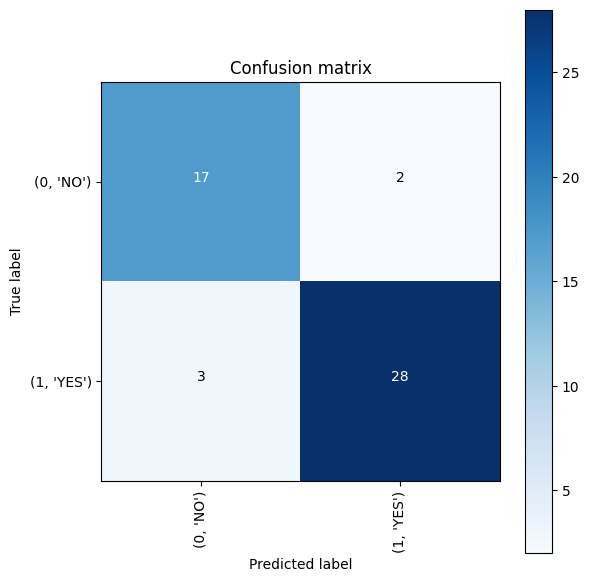

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

1/1 [==============================] - 0s 26ms/step
Test Accuracy = 0.80


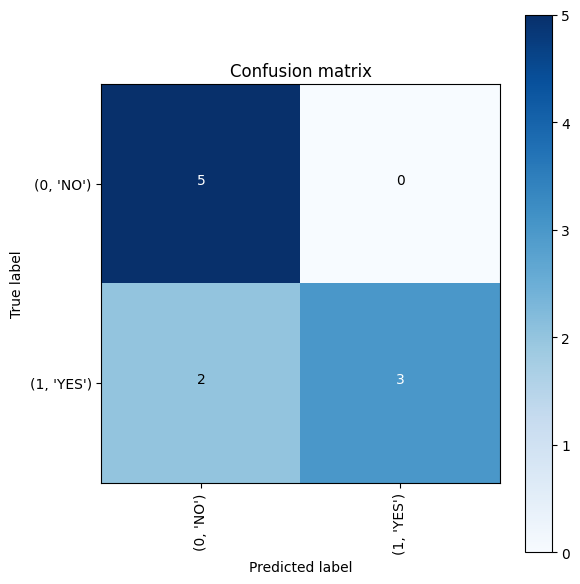

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

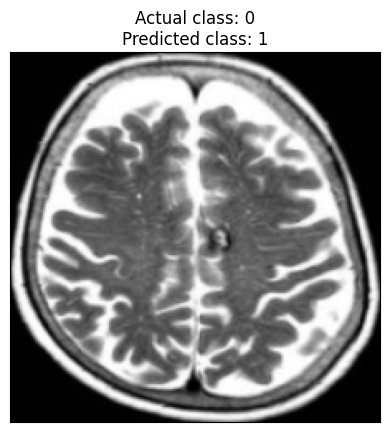

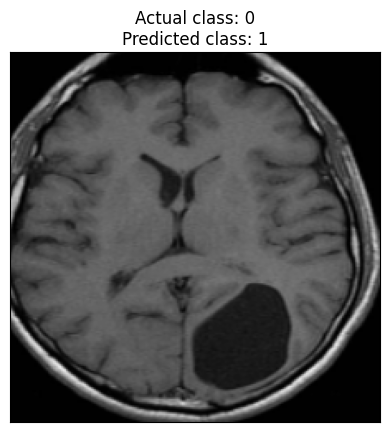

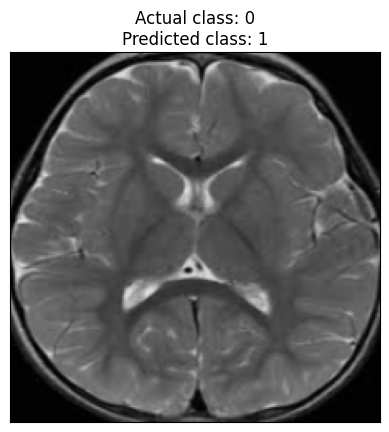

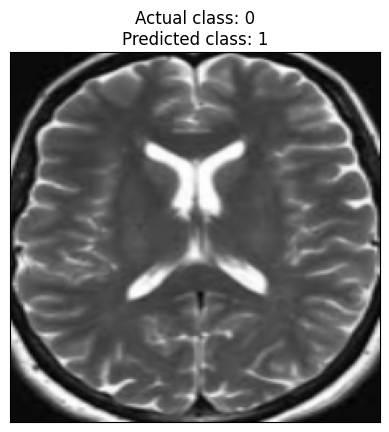

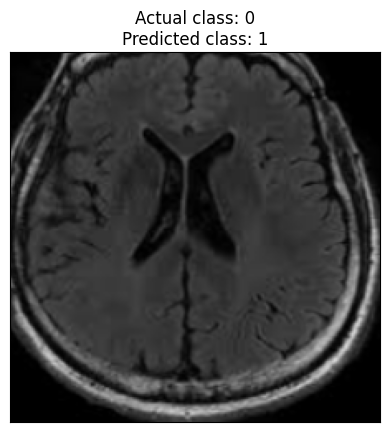

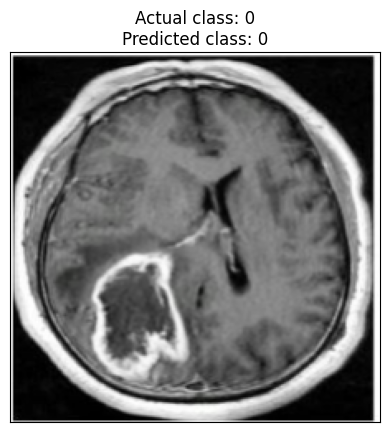

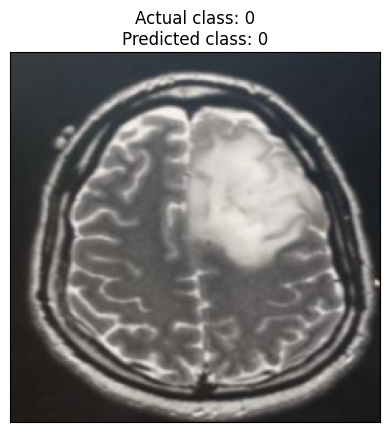

In [ ]:

ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()


1/1 [==============================] - 0s 21ms/step


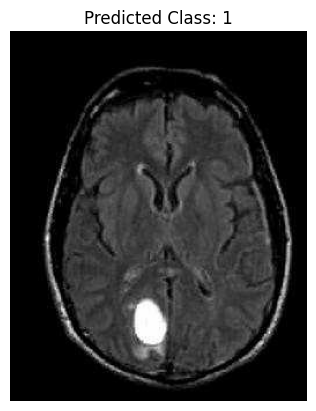

In [ ]:
image_path = 'mritumor.png'
image = cv2.imread(image_path)

# Preprocess the image (crop and resize)
preprocessed_image = crop_imgs([image])
preprocessed_image = preprocess_imgs(preprocessed_image, img_size=(224, 224))

# Make predictions
predictions = model.predict(preprocessed_image)

# Interpret the predictions
# For example, if it's a binary classification model, you can round the predictions to 0 or 1
predicted_class = 1 if predictions[0] > 0.5 else 0

# Display the image and the predicted class
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
image = cv2.imread(image_path)

# Preprocess the image (crop and resize)
preprocessed_image = crop_imgs([image])
preprocessed_image = preprocess_imgs(preprocessed_image, img_size=(224, 224))

# Make predictions
predictions = model.predict(preprocessed_image)

# Interpret the predictions
# For example, if it's a binary classification model, you can round the predictions to 0 or 1
predicted_class = 1 if predictions[0] > 0.5 else 0

# Display the image and the predicted class
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 61ms/step


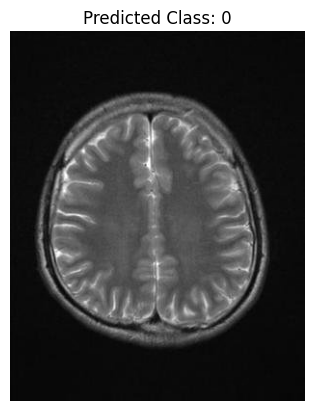

In [ ]:
image_path = 'notumor.png'
image = cv2.imread(image_path)

# Preprocess the image (crop and resize)
preprocessed_image = crop_imgs([image])
preprocessed_image = preprocess_imgs(preprocessed_image, img_size=(224, 224))

# Make predictions
predictions = model.predict(preprocessed_image)

# Interpret the predictions
# For example, if it's a binary classification model, you can round the predictions to 0 or 1
predicted_class = 1 if predictions[0] > 0.5 else 0

# Display the image and the predicted class
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
image = cv2.imread(image_path)

# Preprocess the image (crop and resize)
preprocessed_image = crop_imgs([image])
preprocessed_image = preprocess_imgs(preprocessed_image, img_size=(224, 224))

# Make predictions
predictions = model.predict(preprocessed_image)

# Interpret the predictions
# For example, if it's a binary classification model, you can round the predictions to 0 or 1
predicted_class = 1 if predictions[0] > 0.5 else 0

# Display the image and the predicted class
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()